<a href="https://colab.research.google.com/github/douglascosta01/Redes-Neurais/blob/main/Rede_MLP_e_Melhorias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Carregamento dos pacotes**

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import sklearn.datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

**Dados**






Geração dos Dados


(200,)


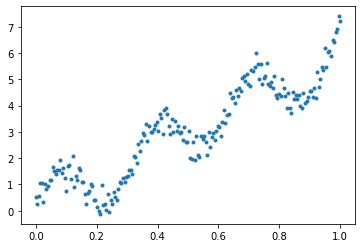

In [6]:
np.random.seed(0)
X = np.arange(0,20,0.1)
Y = np.sin(X) + 0.3*np.random.randn(X.shape[0]) + 0.3*X

X = X / np.max(X)
# Y = Y np.max(Y)
plt.plot(X,Y, '.')
print(X.shape)

**Separação**

Treino/Validação/Teste

(30, 1)
(30, 1)
(140, 1)


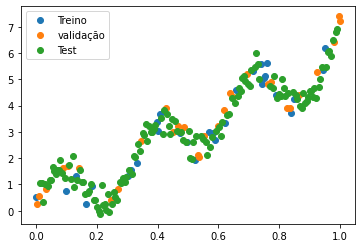

In [7]:
X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

# separação para desenvolvimento (30) e teste (70)
X_dev, X_test, Y_dev, Y_test = train_test_split(X, Y, test_size=0.7,random_state=3)

# separação para treino (80) e validação (20)
X_train, X_val, Y_train, Y_val = train_test_split(X_dev, Y_dev, test_size=0.5, random_state=3)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

plt.plot(X_train, Y_train, 'o', label='Treino')
plt.plot(X_val, Y_val, 'o', label='validação')
plt.plot(X_test, Y_test, 'o', label='Test')
plt.legend()
plt.show()

**Transformação dos dados em tensores Pytorch**

In [8]:
x_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(Y_train)

x_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(Y_val)

x_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(Y_test)

**Modelo 01**

In [9]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(MLP,self).__init__()
    self.rede = nn.Sequential(
        nn.Linear(input_dim,512),
        nn.Tanh(),
        nn.Linear(512,256),
        nn.Tanh(),
        nn.Linear(256,128),
        nn.Tanh(),
        nn.Linear(128,64),
        nn.Tanh(),
        nn.Linear(64,output_dim,)
    )
  def forward(self,x):
    out= self.rede(x)
    return out

**Instanciação do Modelo**

In [10]:
input_dim = 1 # numero de atributos 
output_dim = 1 # numero de classes

modelo = MLP(input_dim, output_dim)

In [11]:
from torchsummary import summary

print(modelo)
summary(modelo, (1,1))

MLP(
  (rede): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]           1,024
              Tanh-2               [-1, 1, 512]               0
            Linear-3               [-1, 1, 256]         131,328
              Tanh-4               [-1, 1, 256]               0
            Linear-5               [-1, 1, 128]          32,896
              Tanh-6               [-1, 1, 128]               0
            Linear-7                [-1, 1, 64]           8,256
              Tanh-8  

**Treinamento**

Otimizador e Função Custo

In [14]:
eta = 0.02
loss_function = nn.MSELoss()
optmizer = torch.optim.SGD(modelo.parameters(),lr=eta)

In [15]:
# verificando disponiblidade de gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Laço de Treinamento da Rede

In [21]:
def train_network(model, optmizer, loss_function, x_train, y_train, x_val, y_val, num_epochs, train_losses, val_losses):
  for epoch in range(num_epochs):
    # zerando os gradientes da época anterior
    optmizer.zero_grad()

    # fase de propagação
    output_train = model(x_train)

    # cálculo do erro (função de custo - loss function)
    loss_train = loss_function(output_train, y_train)

    # fase de retropropagação 
    loss_train.backward()

    # atualização dos pesos da rede
    optmizer.step()

    # avaliando o modelo com o conjunto de validação
    output_val = model(x_val)
    loss_val = loss_function(output_val,y_val)

    train_losses[epoch] = loss_train.item()

    if (epoch + 1) % 500 == 0:
      print(f"Epoch {epoch+1}/{num_epochs}, Erro de Treino: {loss_train.item():.4f}, Erro de validação: {loss_val.item():.3f}")

In [22]:
num_epochs = 10000

train_losses = np.zeros(num_epochs)
val_losses = np.zeros(num_epochs)

train_network(modelo, optmizer, loss_function, x_train, y_train, x_val, Y_val, num_epochs, train_losses, val_losses)

TypeError: ignored